# GPGN268 - Geophysical Data Analysis
## Data Story 03 - Global Warming
#### Due: April 16, 2024 at 9:30 am


For this data Story you will look at [Argo](https://argo.ucsd.edu/) profiles and climatology data. Profiles from two floats are available from Canvas (float `5901429` and float `1901487`). The climatology can be downloaded trhough the [Scripps Argo website](https://sio-argo.ucsd.edu/RG_Climatology.html) selecting the file "2004-2018 RG Argo Temperature Climatology" (You will need ~3 GB of space for that).


You may discuss this assignment with your peers, but everyone should submit their assignment individually. If there is anyone who has *signficantly* contrbuted to your work, helped you figure something important out, etc., list them as a collaborator below with a short description of their input. **Collaborating will not impact your grade**. Please be honest.



### Preparation

- Navigate to the GPGN268-CORE directory and do a `git pull` to get this notebook. 

- Then navigate to your `ds02-global-warming` and copy this notebook to your notebooks directory. 

```
$ cd ~/work/classes/GPGN268/coursework-lastname/ds02-global-warming/
$ cp ~/work/classes/GPGN268/GPGN268-CORE/assignments/DS02-global-warming.ipynb notebooks
```

- Launch Jupyter Lab. Remember to activate the GPGN268 conda environment first.

```
$ conda activate GPGN268
$ jupyter lab
```

- Using the left navigation toolbar in Jupyter Lab, go to the `notebooks` directory rename this notebook to `dev.ipynb`â€“ this will be where you will develop the code for your data story (try things out, make draft figures, etc). **You will not** turn in (i.e., push to GitHub) the `dev.ipynb` file. 

- Create another notebook called `ds02-global-warming.ipynb`. This is where you will put the final version of your Data Story, with polished text, and clean and well-documented code.

- Copy the text below onto the first cell (Markdown) of your `ds02-global-warming.ipynb` notebook and fill it out with your name and date.

```markdown
# GPGN268 - Geophysical Data Analysis
## Data Story 02 - Global Warming

**Student:** Blaster the Burro 
**Collaborators:**
- Yoda helped me figure out how to use the force
- Obi-Wan provided input on my code to plot resistivity
**Date:** May the 4th, 2078
```

- Complete the tasks below. Use this notebook (`dev.ipynb`) to explore and follow the instructions. After your are done with the final version of your assignment, git add `ds02-global-warming.ipynb`, commit, and push to GitHub.

# GPGN268 - Geophysical Data Analysis
## Data Story 03 - Global Warming

**Student:** Lucas Holt

**Collaborators:**

**Date:** 9 April 2024

## Part I â€“ Introducing your story. 

Whatch this [Youtube video](https://www.youtube.com/watch?v=3VUNhHABcB0) and browse the [Argo program website](https://argo.ucsd.edu/). Using the resources above and any other material that comes up on your research, write a couple of paragraphs introducing your Data Story. Some questions to keep in mind are:

- What Argo floats, how do they work, and what do they measure? 
- What data are you going to be looking at and where did it come from?
- What are these type of data used for? What are some scientific/societal applications of this type of observations? 
- How is the data structured (time series, spatial data, 1D, 2D), what is the format of the data, and advantages/disvantages of this particular format?
- What are some common tools used for analyzing and interpreting these type of data?

Argo floats are data collection devices that are released into the ocean to drift around and measure water properties. They take measurements at various water depths by sinking up to 2000 feet, and take measurements at various latitudes and longitudes as they drift. Some of the properties an Argo float might measure are temperature, salinity, and pressure.
These data have numerous applications in the study of global climate and can be used to track ocean warming and sea level rise, among other things. These specific data were collected from two areas: one being in the Southern Ocean and the other being the East Caribbean off the Northern coast of South America.
THe data from the Argo floats are in netcdf files, so we will be using xarray to read, clean, and visualize them. Xarray is an extension of matplotlib that makes visualization of oceanographic data easier. The data will be functions of time and space, as Argo floats can drift around a lot during their journeys.

## Part II - Float analysis
### Task 2.1 â€“ Reading and processing float data
The float data comes with lots of variables that will not be useful for our analysis. In class, we saw how to select specific variables from an `xarray.Dataset` and how to manipulate/organize the variables. The code below illustrates how you would process one file.

```python
# Load the data
ds_raw = xr.load_dataset('float_file1.nc')
# List of variables that we will use
variables = ['TEMP_ADJUSTED','PSAL_ADJUSTED',
             'LATITUDE', 'LONGITUDE', 'JULD']
# Select only these variables from the whole dataset
ds = ds_raw[variables]
# Rename the variable 'JULD' to 'time' and make time a dimension
# (inplace of 'N_PROF') 
ds = ds.rename({'JULD':'time'}).swap_dims({'N_PROF':'time'})
# Change variable names to names that are cleaner and easier to type
ds = ds.rename({'TEMP_ADJUSTED':'temperature',
                'PSAL_ADJUSTED':'salinity',
                'LATITUDE':'latitude',
                'LONGITUDE':'longitude'})
# Defining a common pressure coordinate based on the average
# pressure at each level accross all profiles
mean_pressure = ds_raw.PRES_ADJUSTED.mean(dim='N_PROF')
# Create a new variable "pressure" in the dataset and specify the units
ds['pressure'] = mean_pressure
ds['pressure'].attrs['units'] = 'dbar'
# Make "pressure" on of the dimensions (inplace of 'N_LEVELS')
ds = ds.swap_dims({'N_LEVELS':'pressure'})
```

Use the code above (after making any necessary adjustments) to read the data from one float. After you test for one float, write a function that takes the path to an Argo profile netCDF file as input and returns the cleaned-up dataset. For example:

```python
ds29 = read_float_data('path_to_5901429_prof.nc')
ds87 = read_float_data('path_to_1901487_prof')
```

Document your function and use expressive programming.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def read_float_data(file):
    # open raw netcdf file and create xarray
    ds_raw = xr.open_dataset(file)

    # choose variables to target, create xarray with just these variables
    variables = ['TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'LATITUDE', 'LONGITUDE', 'JULD']
    ds = ds_raw[variables]
    
    # change variable names to make more sense, make time a dimension instead of N_PROF
    ds = ds.rename({'TEMP_ADJUSTED':'temperature', 'PSAL_ADJUSTED':'salinity', 'LATITUDE':'latitude', 'LONGITUDE':'longitude', 'JULD': 'time'})
    ds = ds.swap_dims({'N_PROF':'time'})

    # define a common pressure coordinate based on the average pressure at each level accross all profiles
    mean_pressure = ds_raw.PRES_ADJUSTED.mean(dim='N_PROF')
    
    # create a new variable "pressure" in the dataset and specify the units as decibars
    ds['pressure'] = mean_pressure
    ds['pressure'].attrs['units'] = 'dbar'
    
    # Make pressure a dimension instead of 'N_LEVELS'
    ds = ds.swap_dims({'N_LEVELS':'pressure'})

    return ds

In [3]:
ds29 = read_float_data('../data/5901429_prof.nc')
ds87 = read_float_data('../data/1901487_prof.nc')

### Task 2.2 â€“ Visualizing float temperature and salinity sections

- Use `matplotlib` to plot sections of temperature and salinity for each float as in the figure below:

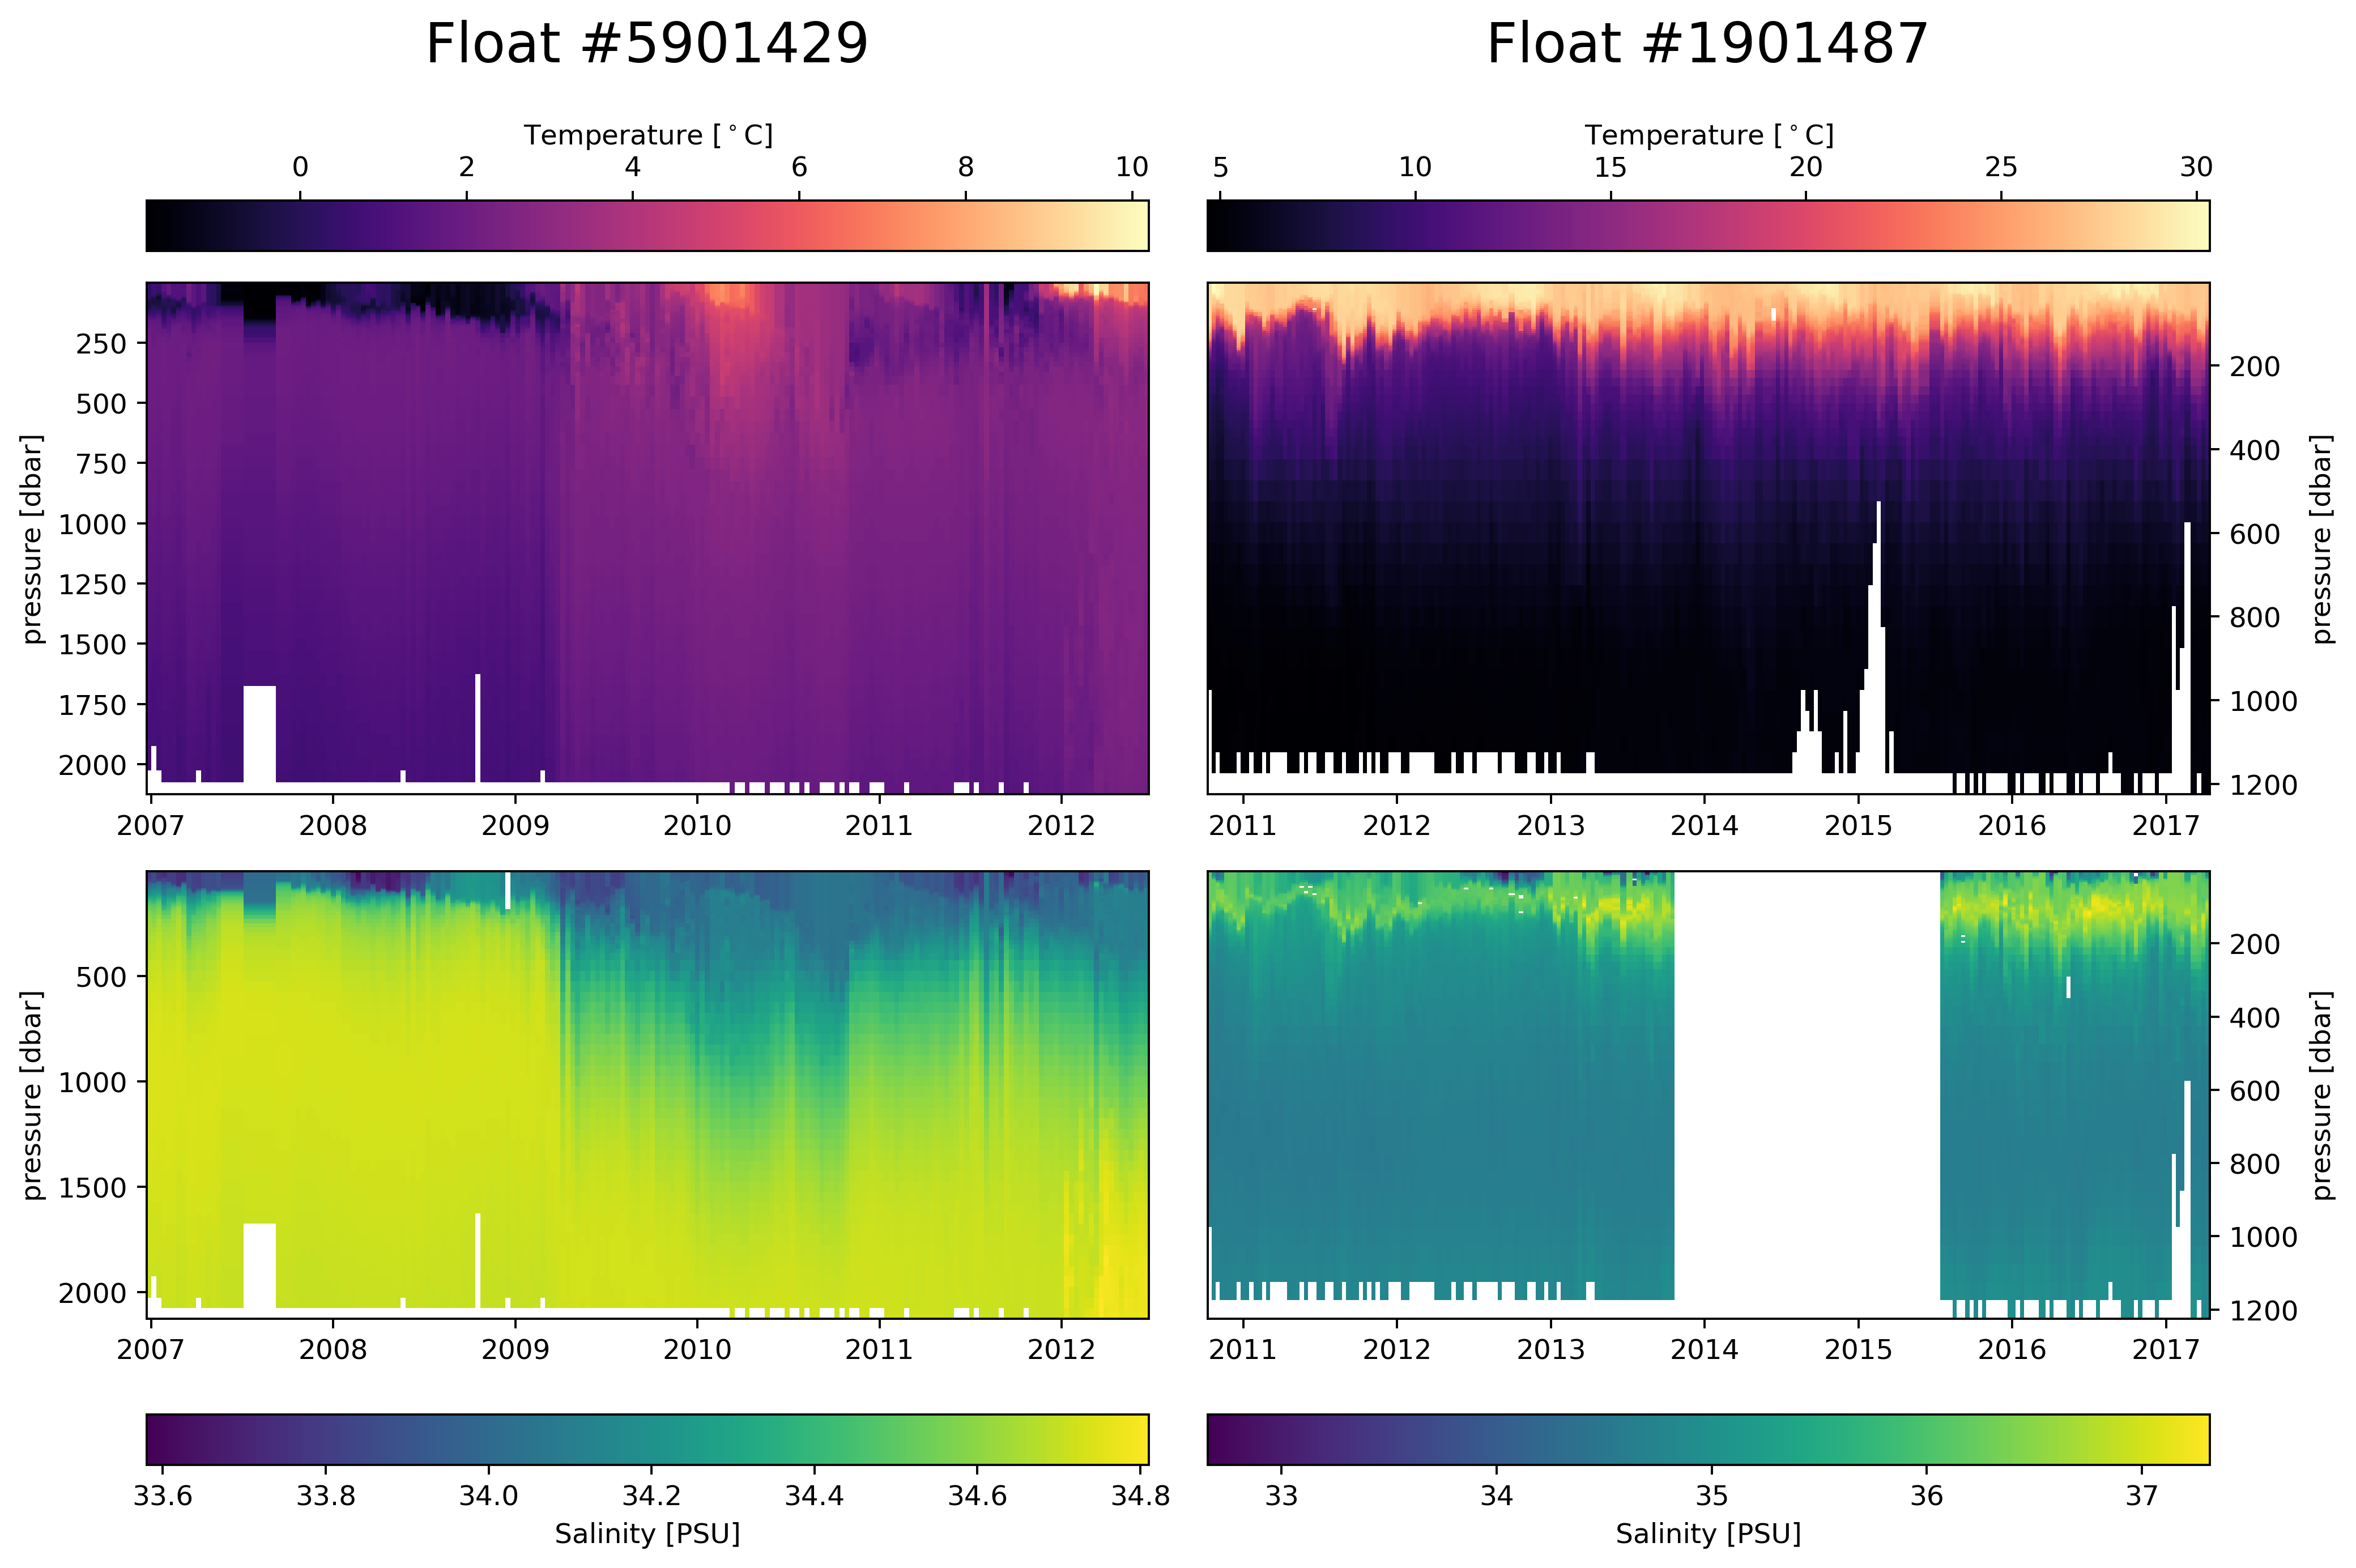

- Properly label your axes and variables. Work on this problem by parts, by trying to plot each variable individually before combining them into a subplot. Here is some code to help you get things into subplots:

```python
fig, axes = plt.subplots(2, 2, figsize=(12,8))
[ax1, ax2, ax3, ax4] = axes.flatten()
# Note you will need to transpose the temperature (using .T) to plot
cs1 = ax1.pcolormesh(ds29.time, ds29.pressure, ds29.temperature.T, cmap='magma')
ax1.invert_yaxis()
ax1.set_ylabel('....................')
ax1.set_title("................", y=1.4, fontsize=20)
cbar1 = plt.colorbar(cs1, ax=ax1,
                     label='................',
                     orientation='..............',
                     location = '.............')

```

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
C:\Users\sahny\AppData\Local\Temp\ipykernel_13556\2599515039.py:8: SyntaxWarning: invalid escape sequence '\c'
  cbar1 = plt.colorbar(cs1, ax=ax1, label='Temperature [$^\circ$C]', location = 'top')
C:\Users\sahny\AppData\Local\Temp\ipykernel_13556\2599515039.py:14: SyntaxWarning: invalid escape sequence '\c'
  cbar2 = plt.colorbar(cs2, ax=ax2, label='Temperature [$^\circ$C]', location = 'top')


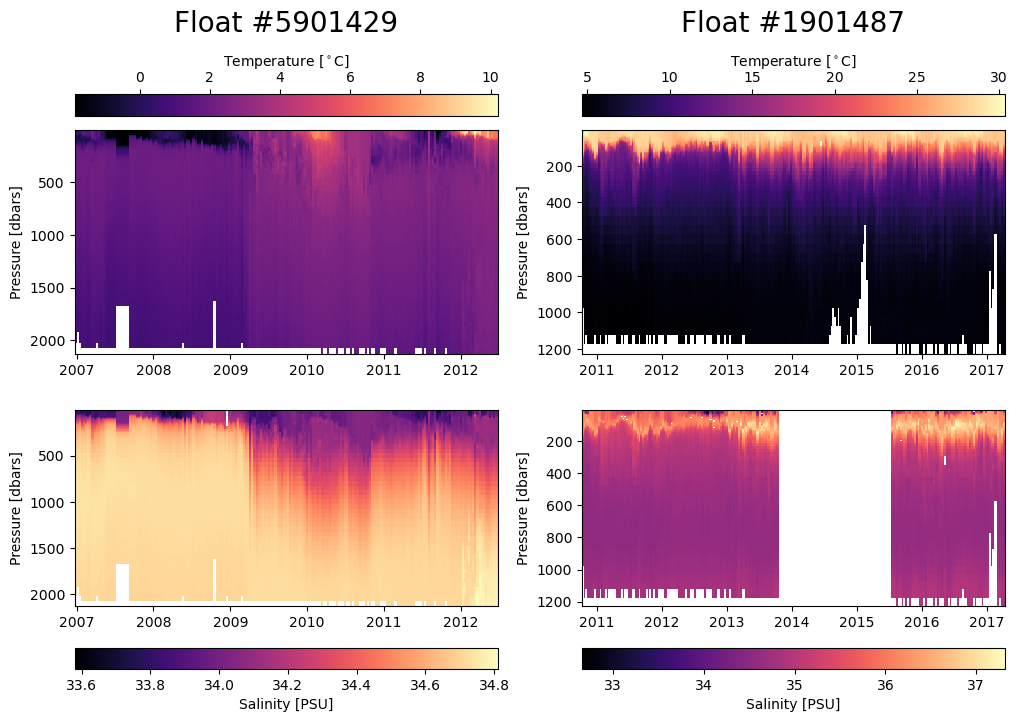

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
[ax1, ax2, ax3, ax4] = axes.flatten()
# Note you will need to transpose the temperature (using .T) to plot
cs1 = ax1.pcolormesh(ds29.time, ds29.pressure, ds29.temperature.T, cmap='magma')
ax1.invert_yaxis()
ax1.set_ylabel('Pressure [dbars]')
ax1.set_title("Float #5901429", y=1.4, fontsize=20)
cbar1 = plt.colorbar(cs1, ax=ax1, label='Temperature [$^\circ$C]', location = 'top')

cs2 = ax2.pcolormesh(ds87.time, ds87.pressure, ds87.temperature.T, cmap='magma')
ax2.invert_yaxis()
ax2.set_ylabel('Pressure [dbars]')
ax2.set_title("Float #1901487", y=1.4, fontsize=20)
cbar2 = plt.colorbar(cs2, ax=ax2, label='Temperature [$^\circ$C]', location = 'top')

cs3 = ax3.pcolormesh(ds29.time, ds29.pressure, ds29.salinity.T, cmap='magma')
ax3.invert_yaxis()
ax3.set_ylabel('Pressure [dbars]')
cbar3 = plt.colorbar(cs3, ax=ax3, label='Salinity [PSU]', location = 'bottom')

cs4 = ax4.pcolormesh(ds87.time, ds87.pressure, ds87.salinity.T, cmap='magma')
ax4.invert_yaxis()
ax4.set_ylabel('Pressure [dbars]')
cbar4 = plt.colorbar(cs4, ax=ax4, label='Salinity [PSU]', location = 'bottom')

### Task 2.3 â€“ Float trajectories

- Use `cartopy` and `matplotlib` to plot the trajectories of each float, like in the figure below:

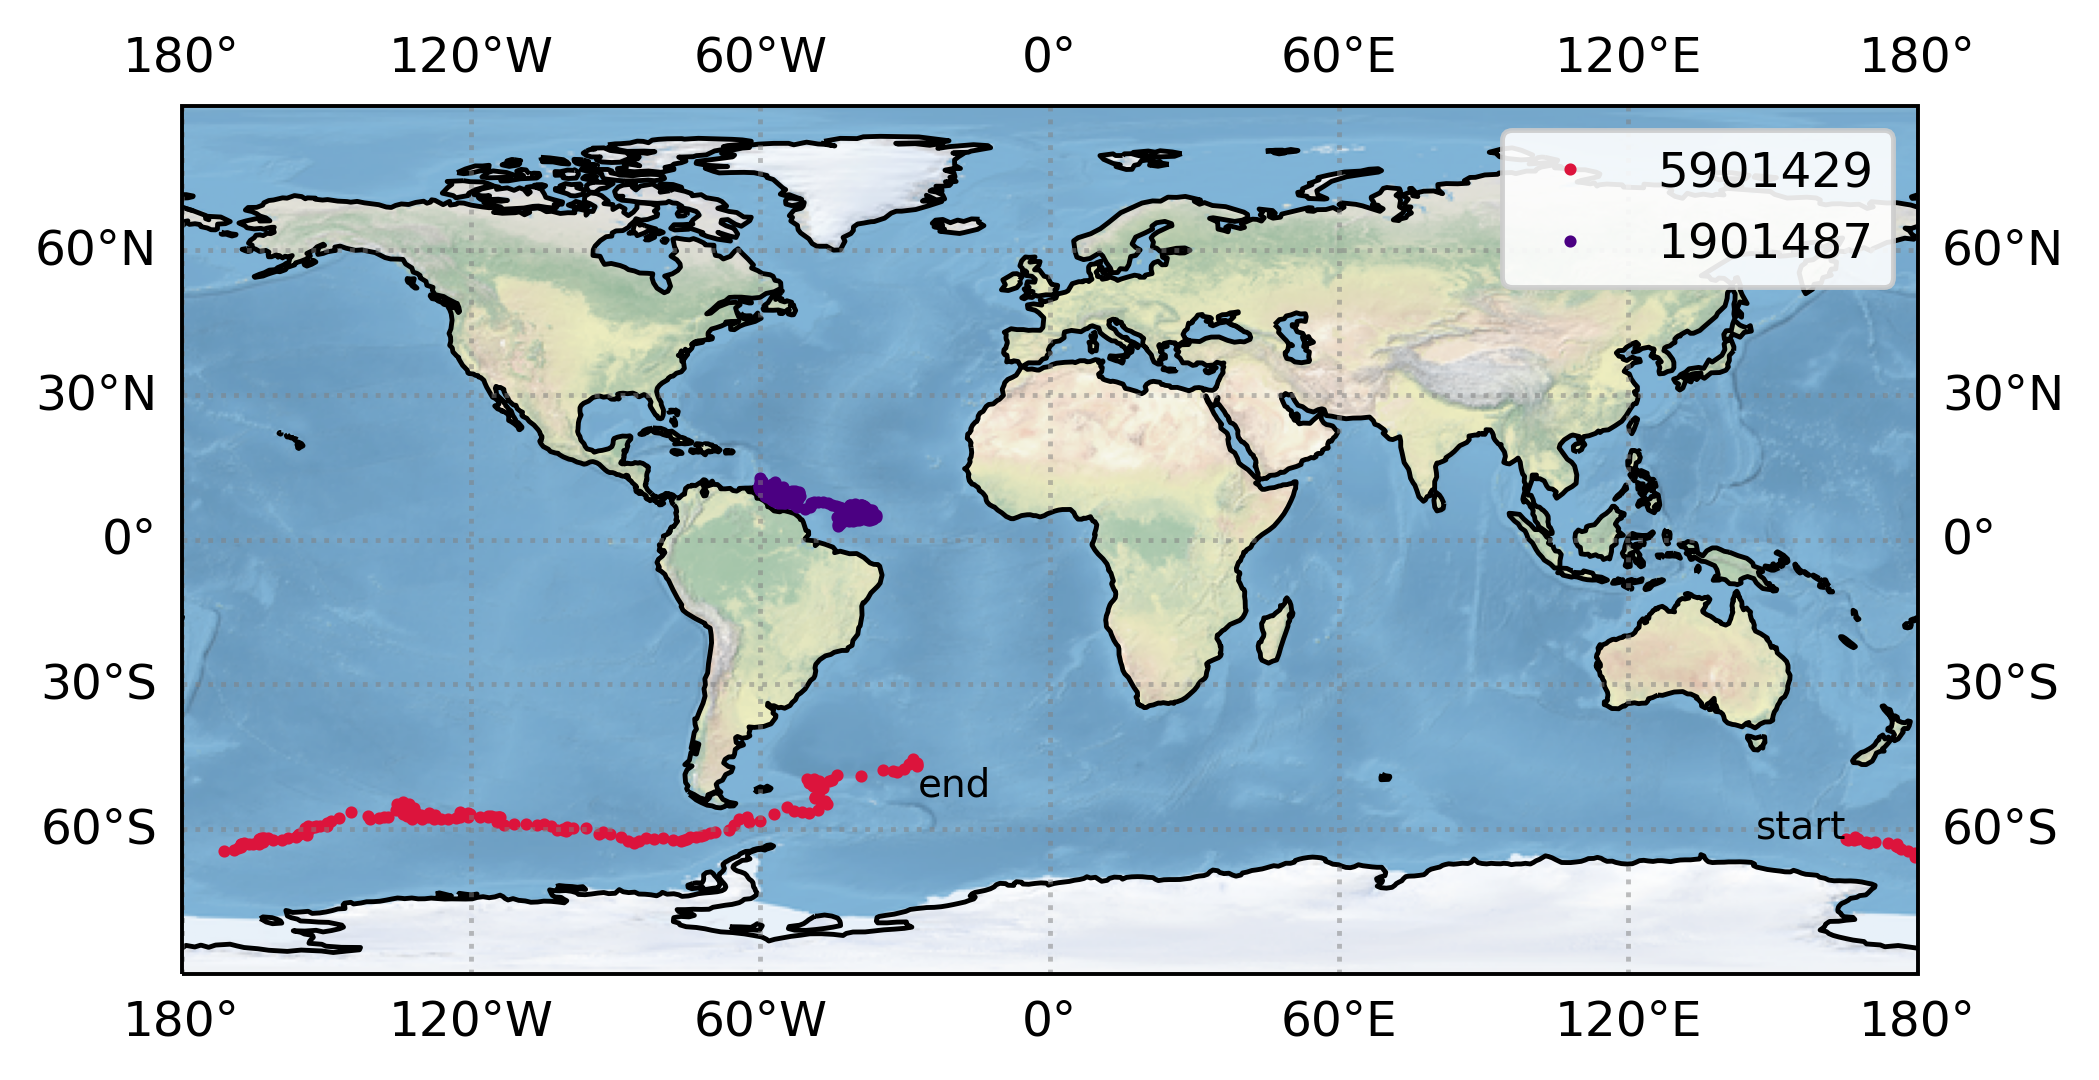

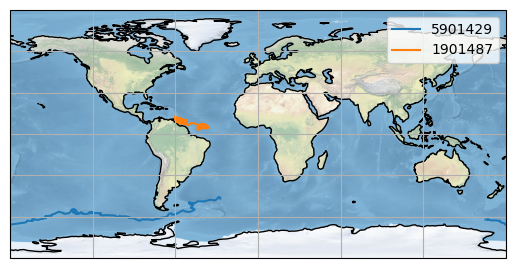

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.plot(ds29.longitude, ds29.latitude, transform=ccrs.Geodetic(), label='5901429')
ax.plot(ds87.longitude, ds87.latitude, transform=ccrs.Geodetic(), label='1901487')
ax.stock_img()
ax.coastlines()
ax.set_global()
ax.gridlines()
ax.legend()

### Task 2.4 â€“ Interpreting ocean temperature and salinity

- Based on the temperature and salinity sections that you produced for Task 2.2 and the float trajectories for Task 2.3, describe and interpret your results. Below are some guiding questions; however, I'm not looking for bullet point answers to each of them, but instead a coherent description of your results in paragraph form, as you would do in a report/paper.

    - What story can you tell from your sections? 
    - How does temperature and salinity vary with time, depth, and geographical locations? 
    - What are some main differences between the observations from float `5901429` and float `1901487`? 
    - Is that consistent with what you would expect? In what way?


The temperature and salinity measurements from floats 5901429 and 1901487 (which I'll call 29 and 87, respectively), are different to due the floats' geographic locations. 29 stayed near 60 $^\circ$S while 87 stayed near the tropics, so it is not surprising that 29 recorded lower ocean temperatures near the surface and at higher depth. 29 also recorded lower salinity overall because cold water does not dissolve solids and gases as well as warm water.

One interesting thing about these data is that they don't show many significant changes in temperature over time. There are also probably not many temperature changes caused by geographic location because the floats stay around the same latitude. However, this might not be the case for salinity. 29 shows a drop in salinity at lower depths starting in 2009, and 87 has a large gap in data between 2014 and 2016. I'm not sure if these are oceanographic or environmental phenomena, or technical difficulties.

### Task 2.5 â€“ Average temperature and salinity profiles

Often times in data analysis, it helps to have two different variables (with different units and scales) plotted on the same plot. We will use the mean temperature and salinity profiles to learn how to do that. 

Based on our map from Task 2.3, float `1901487` didn't move much, but float `5901429` went on a long ride. To gain insight on how ocean properties vary in polar regions, let's select profiles from float `5901429` only at places south of 60$^\circ$S.

```python
south_temp = ds29.temperature[ds29.latitude<-60]
south_sal = .......................
```

Now, we would like to plot the time average temperature and salinity for float `5901429` south of 60$^\circ$S both on the same axis. For that, we are going to use matplotlib's [twiny](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.twiny.html)
function.

```python
fig, ax1 = plt.subplots(figsize=(4, 6))

color = 'tomato'
ax1.plot(south_temp.mean(..........), ............, color=color)
ax1.set_xlabel('..............', color=color)
ax1.set_ylabel('..................')
ax1.set_ylim([0, 800])
ax1.invert_yaxis()
ax1.tick_params(axis='x', labelcolor=color)
ax1.grid(ls='dotted', which='both')

# instantiate a second axes that shares the same y-axis
ax2 = ax1.twiny()
color = 'steelblue'
ax2.plot(................, ....................)
ax2.set_xlabel('................', color=color)
ax2.tick_params(axis='x', labelcolor=color)
```

Modify the code above to produce the plot below (remember to add comments so you understand what each command is doing).

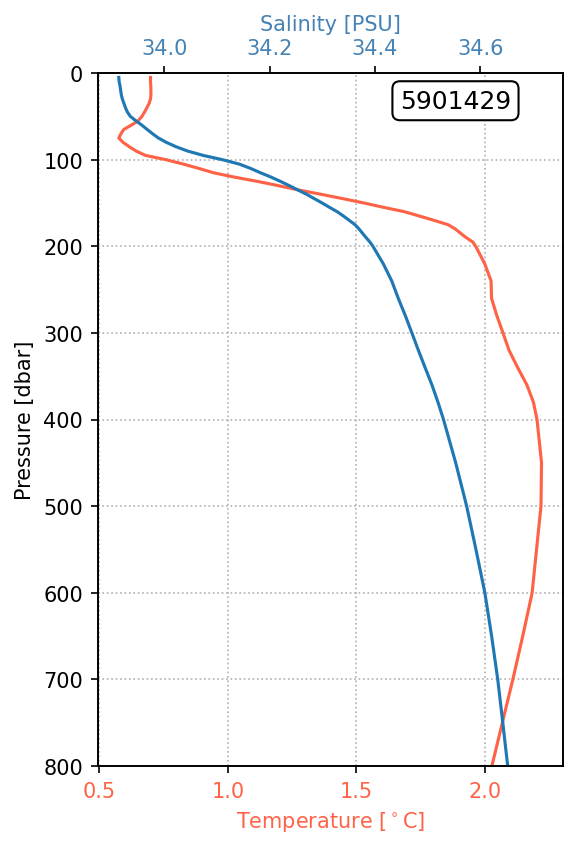


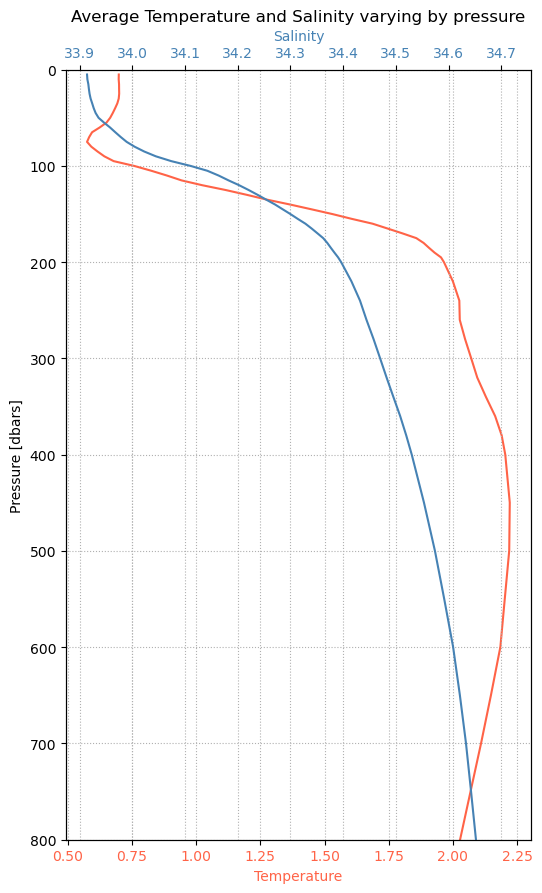

In [6]:
south_temp = ds29.temperature[ds29.latitude<-60]
south_sal = ds29.salinity[ds29.latitude<-60]

fig, ax1 = plt.subplots(1, 1, figsize=(6,10))

color = 'tomato'
ax1.plot(south_temp.mean(dim='time'), ds29.pressure, color=color)
ax1.set_xlabel('Temperature', color=color)
ax1.set_ylabel('Pressure [dbars]')
ax1.set_ylim([0, 800])
ax1.invert_yaxis()
ax1.tick_params(axis='x', labelcolor=color)
ax1.grid(ls='dotted', which='both')
ax1.set_title('Average Temperature and Salinity varying by pressure')

ax2 = ax1.twiny()
color = 'steelblue'
ax2.plot(south_sal.mean(dim='time'), ds29.pressure, color=color)
ax2.set_xlabel('Salinity', color=color)
ax2.set_ylabel('Pressure [dbars]')
ax2.set_ylim([0, 800])
ax2.invert_yaxis()
ax2.tick_params(axis='x', labelcolor=color)
ax2.grid(ls='dotted', which='both')

## Part III - Climatology analysis

For this part of your Data Story, we will be looking at a product that represents a [climatology](https://en.wikipedia.org/wiki/Climatology) of Argo float data between 2004 and 2019. These are monthly averaged temperature measurements from all available Argo floats, which were gridded on a $1^\circ \times 1^\circ$ grid. You can read more about this product [here](https://sio-argo.ucsd.edu/RG_Climatology.html).


### Task 3.1 â€“ Reading and processing climatology data

- If you try to load the climatology file, you will get an error. Explain (in writing) what this error is and how to fix it. 
- Load the data into a dataset

```python
ds = xr.open_dataset('path_to_climatology_RG_ArgoClim_Temperature_2019.nc', ..........)
```

Now, you will see that the variable 'TIME' has units of "months since 2004-01-01 00:00:00" and one of its attributes is "time_origin". We would like out time to be in [numpy.datetime64](https://numpy.org/doc/stable/reference/arrays.datetime.html) format so we can easly do opperations with our data. We will have to manually create a time variable and substitute that on our dataset

```python
# Create a variable with the date of our first data point (origin)
t0 = np.datetime64("2004-01")
# Create a sequence representing the number 
# of months since 2004-01 ranging from 0 to 179
months = range(len(ds.TIME))
# Create and array of dates where you add 1...179 months 
# to the origin date t0
time = np.array([t0 + np.timedelta64(m, "M") for m in months])
```

After running the steps above, check what the variable `time` is so you understand what we just did.

Now we will do some clean up on our dataset and add the correct time variable

```python
ds = ds.rename({'TIME':'time'})
ds = ds.rename({'ARGO_TEMPERATURE_MEAN':'temp_mean',
                'ARGO_TEMPERATURE_ANOMALY':'temp_anom',
                'PRESSURE':'pressure',
                'LATITUDE':'latitude',
                'LONGITUDE':'longitude'})
# Replace the old values with the time array that we created
ds['time'] = time
```

- Look at what `ds` is and write a short explanation of what this data structure represents.

Attempting to load the climatology file with xarray.open_dataset leads to an error because the time units are months since the 1st of January, 2004.
To fix this, we can specify decode_times=False in the arguments.

In [7]:
ds = xr.open_dataset('../data/RG_ArgoClim_Temperature_2019.nc.gz', decode_times=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sahny\\work\\classes\\GPGN268\\coursework-holt\\ds03-global-warming\\data\\RG_ArgoClim_Temperature_2019.nc.gz'

In [ ]:
# Create a variable with the date of our first data point (origin)
t0 = np.datetime64("2004-01")
# Create a sequence representing the number 
# of months since 2004-01 ranging from 0 to 179
months = range(len(ds.TIME))
# Create and array of dates where you add 1...179 months 
# to the origin date t0
time = np.array([t0 + np.timedelta64(m, "M") for m in months])

# creates array 'time' of np.datetime64 objects

In [ ]:
ds = ds.rename({'TIME':'time'})
ds = ds.rename({'ARGO_TEMPERATURE_MEAN':'temp_mean',
                'ARGO_TEMPERATURE_ANOMALY':'temp_anom',
                'PRESSURE':'pressure',
                'LATITUDE':'latitude',
                'LONGITUDE':'longitude'})
# Replace the old values with the time array that we created
ds['time'] = time

This data structure represents global average temperature and temperature anomaly, taken by all Argo floats and averaged monthly.

#### ðŸ¤¯ Bonus on hvplot

Python has an iteractive plotting library called [hvplot](https://hvplot.holoviz.org/). We can quickly plot the depth (pressure) averaged temperature by running:

```python
import hvplot.xarray

depth_ave_temp = ds.temp_anom.mean(dim='pressure')
depth_ave_temp.hvplot('longitude', 'latitude', cmap='RdBu_r', clim=(-3, 3))
```

In [ ]:
import hvplot.xarray

depth_ave_temp = ds.temp_anom.mean(dim='pressure')
depth_ave_temp.hvplot('longitude', 'latitude', cmap='RdBu_r', clim=(-3, 3))

### Task 3.2 â€“ Seasonal Averages

Similarly to `pandas`, `xarray` has a very clever way of grouping data to perform opperations. We would like to plot maps of pressure-averaged temperature averaged over each season. We will use the metho [groupby](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html) to perform this operation. Here, we're grouping the data by season and computing the average. 

```python
seasonal_temp = depth_ave_temp.groupby("time.season").mean()
```

This works for other time periods too. You could try to use "time.year" for an yearly average, for example.

- Look at the variable `seasonal_temp`, its dimansion and coordinates to understand what happend.

- Use `matplotlib`, `cartopy`, and the code snippets below to make seasonal maps of temperature anomaly.

- Describe is plotted on the maps and interpret your results


```python

# Define limits for the colorbar
vmin = -1
vmax = 1
# Creates four subplots (2 rows and 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, s in enumerate(seasonal_temp.season):
    ax = axes[i]
    cs = ax.pcolormesh(....., ....., seasonal_temp.sel(season=....),
                       transform = ccrs.PlateCarree(),
                       vmin=vmin,vmax=vmax,cmap='RdBu_r')
    ax.set_title("{}".format(s.values))
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray',
                  alpha=0.5, linestyle='dotted')
    gl.top_labels = False
    gl.right_labels = False

cax = fig.add_axes([0.99, 0.35, 0.02, 0.4])
cbar = plt.colorbar(cs, cax=cax,label='.............')
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.3, hspace=0.01)
```


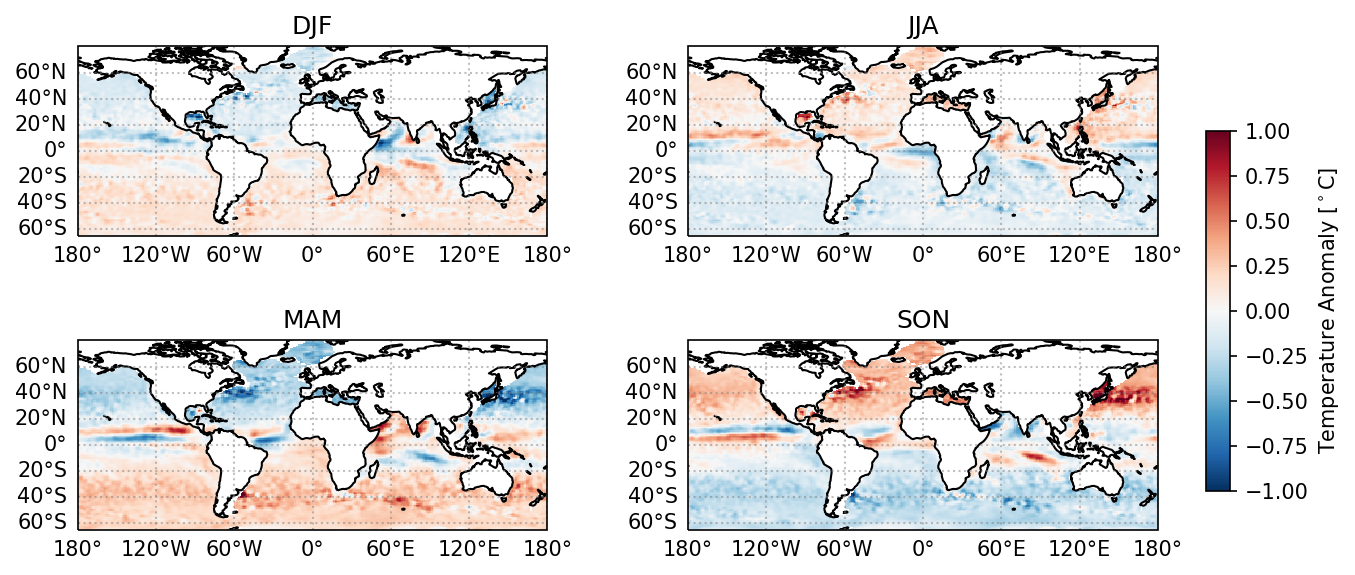

In [ ]:
seasonal_temp = depth_ave_temp.groupby("time.season").mean()

In [ ]:
# Define limits for the colorbar
vmin = -1
vmax = 1
# Creates four subplots (2 rows and 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

seasons = ['DJF', 'MAM', 'JJA', 'SON']

for i, s in enumerate(seasonal_temp.season):
    ax = axes[i]
    cs = ax.pcolormesh(ds['longitude'], ds['latitude']
                       , seasonal_temp.sel(season=seasons[i]),
                       transform = ccrs.PlateCarree(),
                       vmin=vmin,vmax=vmax,cmap='RdBu_r')
    ax.set_title("{}".format(s.values))
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray',
                  alpha=0.5, linestyle='dotted')
    gl.top_labels = False
    gl.right_labels = False

cax = fig.add_axes([0.99, 0.35, 0.02, 0.4])
cbar = plt.colorbar(cs, cax=cax,label='Temperature [$^\circ$C]')
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.3, hspace=0.01)


### Task 3.3 â€“ Ocean Warming

- Now, we will look at the temporal evolution of the global mean ocean temperature in the past 15 years. What do you see in the data? 

```python
global_mean = ds.depth_ave_temp.mean(dim=[...., ....])
global_mean.plot()
```

In other to minimy the fluctuations and focus on the long-term evolution of the temperature, we will apply a technique that is commonly used in geosciences: smoothing. We will use `xarray`'s method [rolling](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html) to smooth the data every 12 months (equivalent to 12-points in the time dimension in our case)

```python
running_mean = global_mean.rolling(time=12, center=True).mean()
```

- Use matplotlib to reproduce the figure below

![global_warming.png](attachment:83ef7e88-2cbb-4f83-bbd0-fa9a502e1ddd.png)

The early 2000s was marked by what scientists call a "hiatus", where the trend in ocean warming flattened. Around 2012 the temperature anomaly started to pick up again. 

- Using any method of your choice (including eye-balling), estimate the temperature trend between 2012 and 2018 and give your final answer in units of **degrees Celsius per decade**. Do some research to check if this is comparable with values described in the literature/web. Include links to your references in your answer.

In [ ]:
global_mean = depth_ave_temp.mean(dim=['longitude', 'latitude'])
global_mean.plot(label='mean ocean temperature')

running_mean = global_mean.rolling(time=12, center=True).mean()
running_mean.plot(label='12-month smoothing')

2018 value: ~0.045 $^\circ$C

2012 value: ~-0.020 $^\circ$C

Trend: 0.045+0.020 / 2018-2012 = 0.0011 $^\circ$C / year

0.0011 $^\circ$C / year * 10 years / 1 decade = 0.011 $^\circ$C / decade

Reference: NOAA Global Temperature Anomaly Time Series - https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/ocean/ytd/0/2004-2018

2018 value: ~0.66 $^\circ$C

2012 value: ~0.35 $^\circ$C

Trend: 0.66-0.35 / 2018-2012 = 0.052 $^\circ$C / year

0.052 $^\circ$C / year * 10 years / 1 decade = 0.52 $^\circ$C / decade

This is unfortunately not that close to my measured value from the plot.